In [12]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [13]:
dataset = 'model/keypoint_classifier/alphakeypoints.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

In [14]:
NUM_CLASSES = 21

In [15]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (42 * 2) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

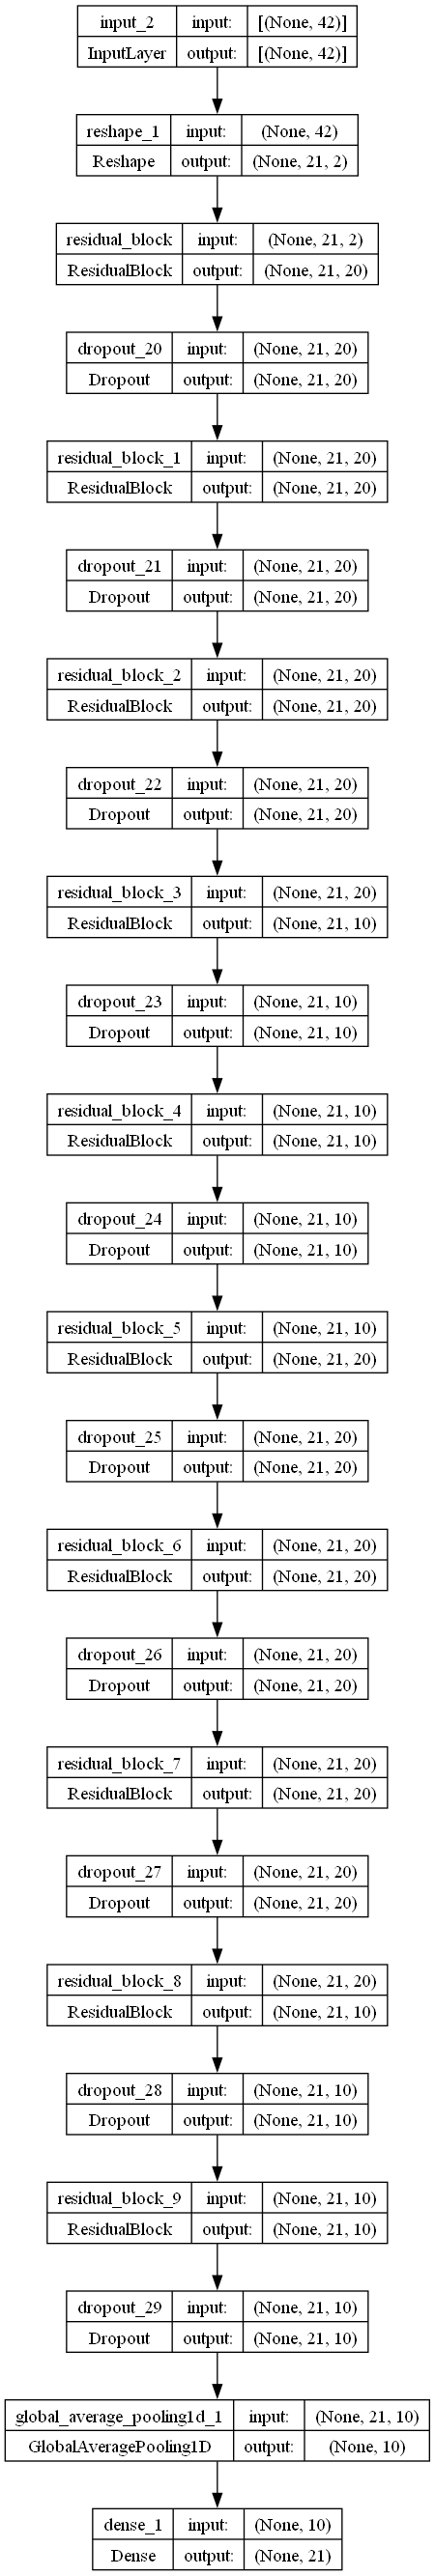

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, BatchNormalization, Activation, Reshape, GlobalAveragePooling1D, Add, MultiHeadAttention, LayerNormalization
from tensorflow.keras.activations import swish  
from tensorflow.keras.utils import plot_model

def TCNBlock(x, filters, kernel_size=3, dilation_rate=1):
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = LayerNormalization()(x)
    x = swish(x)
    return x

class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=3, use_attention=False, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.use_attention = use_attention

    def build(self, input_shape):
        self.conv1 = Conv1D(self.filters, self.kernel_size, padding='same')
        self.norm1 = BatchNormalization()
        self.conv2 = Conv1D(self.filters, self.kernel_size, padding='same')
        self.norm2 = BatchNormalization()
        self.attention = MultiHeadAttention(num_heads=4, key_dim=self.filters)
        super(ResidualBlock, self).build(input_shape)

    def call(self, inputs):
        x = inputs
        shortcut = self.conv1(x)
        x = TCNBlock(x, filters=self.filters, kernel_size=self.kernel_size)
        if self.use_attention:
            att = self.attention(x, x)
            x = Add()([x, att])
        x = self.conv2(x)
        x = self.norm2(x)
        x = Add()([x, shortcut])
        x = swish(x)
        return x

input_layer = Input(shape=(42 * 2,))

x = Reshape((21, 2))(input_layer)

x = ResidualBlock(filters=20, use_attention=True)(x)
x = Dropout(0.2)(x)

x = ResidualBlock(filters=20, use_attention=True)(x)
x = Dropout(0.2)(x)

x = ResidualBlock(filters=20, use_attention=True)(x)  
x = Dropout(0.2)(x)

x = ResidualBlock(filters=10, use_attention=True)(x)
x = Dropout(0.4)(x)

x = ResidualBlock(filters=10, use_attention=True)(x)  
x = Dropout(0.4)(x)

x = ResidualBlock(filters=20, use_attention=True)(x)
x = Dropout(0.2)(x)

x = ResidualBlock(filters=20, use_attention=True)(x)
x = Dropout(0.2)(x)

x = ResidualBlock(filters=20, use_attention=True)(x)  
x = Dropout(0.2)(x)

x = ResidualBlock(filters=10, use_attention=True)(x)
x = Dropout(0.2)(x)

x = ResidualBlock(filters=10, use_attention=True)(x)  
x = Dropout(0.2)(x)

x = GlobalAveragePooling1D()(x)

output_layer = Dense(21, activation='softmax')(x)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 84)                0         
                                                                 
 dense (Dense)               (None, 20)                1700      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 21)                231       
                                                                 
Total params: 2,141
Trainable params: 2,141
Non-trainable params: 0
_________________________________________________________________


In [10]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
671/676 [============================>.] - ETA: 0s - loss: 2.0399 - accuracy: 0.3787
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
676/676 [==============================] - 9s 10ms/step - loss: 2.0357 - accuracy: 0.3800 - val_loss: 1.0514 - val_accuracy: 0.7221
Epoch 2/1000
672/676 [============================>.] - ETA: 0s - loss: 1.3655 - accuracy: 0.5703
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
676/676 [==============================] - 7s 10ms/step - loss: 1.3648 - accuracy: 0.5704 - val_loss: 0.7832 - val_accuracy: 0.8061
Epoch 3/1000
674/676 [============================>.] - ETA: 0s - loss: 1.2128 - accuracy: 0.6177
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
676/676 [==============================] - 7s 10ms/step - loss: 1.2127 - accuracy: 0.6178 - val_loss: 0.6949 - val_accuracy: 0.8177
Epoch 4/1000
674/676 [============================>.] - ETA: 0s - loss: 1.1383 - a

Epoch 28/1000
673/676 [============================>.] - ETA: 0s - loss: 0.9316 - accuracy: 0.7129
Epoch 28: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
676/676 [==============================] - 6s 9ms/step - loss: 0.9316 - accuracy: 0.7130 - val_loss: 0.4675 - val_accuracy: 0.8883
Epoch 29/1000
673/676 [============================>.] - ETA: 0s - loss: 0.9284 - accuracy: 0.7160
Epoch 29: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
676/676 [==============================] - 6s 9ms/step - loss: 0.9281 - accuracy: 0.7161 - val_loss: 0.4659 - val_accuracy: 0.8874
Epoch 30/1000
675/676 [============================>.] - ETA: 0s - loss: 0.9243 - accuracy: 0.7177
Epoch 30: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
676/676 [==============================] - 6s 9ms/step - loss: 0.9245 - accuracy: 0.7177 - val_loss: 0.4650 - val_accuracy: 0.8862
Epoch 31/1000
674/676 [============================>.] - ETA: 0s - loss: 0.9249

Epoch 55/1000
674/676 [============================>.] - ETA: 0s - loss: 0.8900 - accuracy: 0.7283
Epoch 55: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
676/676 [==============================] - 6s 9ms/step - loss: 0.8901 - accuracy: 0.7282 - val_loss: 0.4385 - val_accuracy: 0.8898
Epoch 56/1000
676/676 [==============================] - ETA: 0s - loss: 0.8942 - accuracy: 0.7263
Epoch 56: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
676/676 [==============================] - 6s 9ms/step - loss: 0.8942 - accuracy: 0.7263 - val_loss: 0.4531 - val_accuracy: 0.8852
Epoch 57/1000
676/676 [==============================] - ETA: 0s - loss: 0.8970 - accuracy: 0.7267
Epoch 57: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
676/676 [==============================] - 6s 9ms/step - loss: 0.8970 - accuracy: 0.7267 - val_loss: 0.4479 - val_accuracy: 0.8865
Epoch 58/1000
676/676 [==============================] - ETA: 0s - loss: 0.8949

Epoch 82/1000
670/676 [============================>.] - ETA: 0s - loss: 0.8775 - accuracy: 0.7302
Epoch 82: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
676/676 [==============================] - 6s 9ms/step - loss: 0.8777 - accuracy: 0.7300 - val_loss: 0.4460 - val_accuracy: 0.8855
Epoch 83/1000
672/676 [============================>.] - ETA: 0s - loss: 0.8790 - accuracy: 0.7320
Epoch 83: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
676/676 [==============================] - 6s 9ms/step - loss: 0.8796 - accuracy: 0.7320 - val_loss: 0.4342 - val_accuracy: 0.8877
Epoch 84/1000
676/676 [==============================] - ETA: 0s - loss: 0.8816 - accuracy: 0.7299
Epoch 84: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
676/676 [==============================] - 6s 9ms/step - loss: 0.8816 - accuracy: 0.7299 - val_loss: 0.4407 - val_accuracy: 0.8854
Epoch 85/1000
676/676 [==============================] - ETA: 0s - loss: 0.8794

In [13]:
# 
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

226/226 [==============================] - 1s 5ms/step - loss: 0.4439 - accuracy: 0.8843


In [14]:
model = tf.keras.models.load_model(model_save_path)

In [15]:

predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 377ms/step
[3.0858221e-03 2.4542128e-04 7.8934914e-04 1.8824542e-04 1.1420690e-02
 6.4341263e-03 4.1094822e-06 2.7354699e-04 1.6816335e-07 6.0463281e-06
 7.5342492e-03 6.5359971e-05 2.3659377e-05 5.1094189e-06 6.6833343e-07
 1.6544526e-09 6.8306255e-01 1.2129553e-05 2.7617637e-06 3.0647170e-02
 2.5619879e-01]
16


902/902 [==============================] - 3s 4ms/step


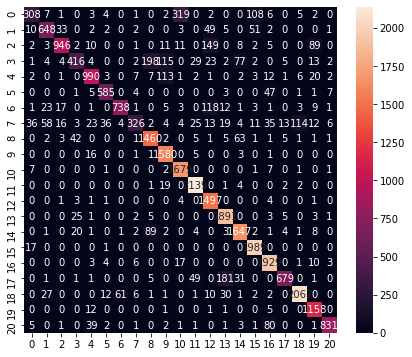

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.40      0.53       768
           1       0.84      0.80      0.82       808
           2       0.92      0.76      0.84      1239
           3       0.81      0.46      0.59       897
           4       0.89      0.84      0.87      1173
           5       0.90      0.89      0.90       654
           6       0.92      0.79      0.85       937
           7       0.90      0.43      0.58       764
           8       0.83      0.92      0.87      1594
           9       0.85      0.98      0.91      1607
          10       0.82      0.99      0.90      1699
          11       0.95      0.99      0.97      2168
          12       0.80      0.99      0.89      1512
          13       0.88      0.98      0.92      1936
          14       0.89      0.92      0.91      1786
          15       0.91      0.99      0.95      2007
          16       0.90      0.98      0.94      1973
     

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [17]:
model.save(model_save_path, include_optimizer=False)

In [18]:
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\shadow\AppData\Local\Temp\tmpw09d2zkg\assets


5648

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 993 µs


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.1663640e-03 2.4416859e-04 7.7514065e-04 1.7645543e-04 1.1041151e-02
 6.3310945e-03 4.1436765e-06 2.7451720e-04 1.5382579e-07 5.1698989e-06
 7.8173485e-03 6.0151018e-05 2.2320941e-05 4.6795221e-06 6.3245773e-07
 1.8386550e-09 6.8349135e-01 1.0813566e-05 2.7872227e-06 2.9485645e-02
 2.5708592e-01]
16
